In [2]:
using LinearAlgebra
using SparseArrays
using Plots

In [3]:
function xy(
    x0::Float64, 
    y0::Float64, 
    L1::Float64, 
    L2::Float64, 
    noelms1::Int64, 
    noelms2::Int64
)::Tuple{Vector{Float64}, Vector{Float64}}
    VX = repeat(collect(LinRange(x0, x0+L1, noelms1+1)), inner=noelms2+1)
    VY = repeat(collect(LinRange(y0+L2, y0, noelms2+1)), noelms1+1)
    return VX, VY
end

function conelmtab(noelms1::Int64, noelms2::Int64)::Matrix{Int64}
    k = [i for i in 1:(noelms1*(noelms2+1)) if i % (noelms2+1) != 0]

    return [
        k (2 + noelms2 .+ k) (1 + noelms2 .+ k);
        k (1 .+ k) (2 + noelms2 .+ k)
    ]
end

function basfun(
    VX::Vector{Float64}, 
    VY::Vector{Float64}, 
    EToV::Matrix{Int64}
)::Tuple{Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}
    xjs = VX[EToV[:, [2,3,1]]]
    yjs = VY[EToV[:, [2,3,1]]]

    xks = VX[EToV[:, [3,1,2]]]
    yks = VY[EToV[:, [3,1,2]]]

    as = xjs .* yks - xks .* yjs
    bs = yjs - yks
    cs = xks - xjs

    return as, bs, cs
end

function constructBnodes(
    VX::Vector{Float64},
    VY::Vector{Float64},
    tol::Float64,
    fd::Function,
)::Vector{Int64}
    return findall(abs.(fd.(VX, VY)) .<= tol)
end

constructBnodes (generic function with 1 method)

# Exercise 5.1

In [4]:
function assembly(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    lam1::Float64,
    lam2::Float64,
    qt::Vector{Float64},
    c::Vector{Float64}
)::Tuple{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Vector{Float64}}
    N = size(EToV)[1]
    M = length(VX)

    A = spzeros(M, M)
    C = spzeros(M, M)
    b = zeros(M)

    ats, bts, cts = basfun(VX, VY, EToV)
    deltas = abs.(sum(ats, dims=2) ./ 2)
    qs = deltas .* sum(qt[EToV], dims=2) / 9
    cs = sum(c[EToV], dims=2) / 3
    c_matrix = Diagonal(fill(1/12, 3)) + fill(1/12,3,3) # specific heat matrix for computation

    for n in 1:N
        delta = deltas[n]
        cn_matrix = c_matrix .* delta .* cs[n]
        q = qs[n]
        bt = bts[n, :]
        ct = cts[n, :]

        for r in 1:3
            i = EToV[n,r]
            b[i] += q

            for s in r:3
                j = EToV[n,s]
                kn = (lam1*bt[r]*bt[s] + lam2*ct[r]*ct[s]) / (4 * delta)
                A[min(i, j), max(i, j)] += kn
                C[min(i, j), max(i ,j)] += cn_matrix[r,s]
            end
        end
    end

    return A, C, b
end

assembly (generic function with 1 method)

In [14]:
function dirbc(
    bnodes::Vector{Int64}, 
    f::Vector{Float64}, 
    A::SparseMatrixCSC{Float64, Int64}, 
    C::SparseMatrixCSC{Float64, Int64}, 
    b::Vector{Float64}
)::Tuple{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Vector{Float64}, Vector{Float64}}
    d = zeros(length(b))
    for (i, k) in enumerate(bnodes)
        b[k] = 0

        indices1A = findall(A[1:k-1, k] .!= 0) 
        indices2A = findall(A[k, 1+k:end] .!= 0) .+ k
        indices1C = findall(C[1:k-1, k] .!= 0) 
        indices2C = findall(C[k, 1+k:end] .!= 0) .+ k

        temp1 = A[indices1A,k] .* f[i]
        temp2 = A[k,indices2A] .* f[i]

        b[indices1A] -= temp1
        b[indices2A] -= temp2

        d[indices1A] += temp1
        d[indices2A] += temp2

        A[indices1A, k] .= 0
        A[k, indices2A] .= 0
        C[indices1C, k] .= 0
        C[k, indices2C] .= 0
        
        A[k, k] = 0
        C[k, k] = 1
    end

    return A, C, b, d
end

dirbc (generic function with 1 method)

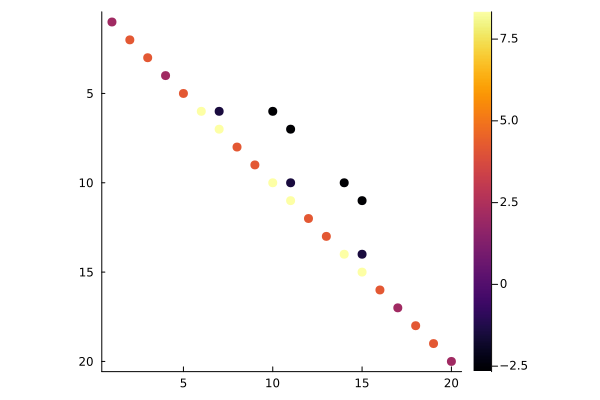

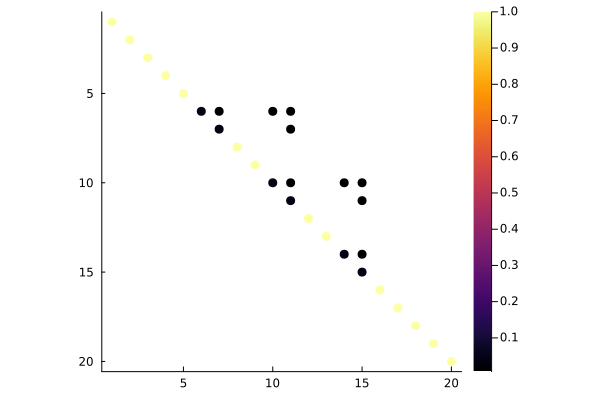

20-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 4.166666666666668
 4.166666666666667
 0.0
 0.0
 1.5
 1.5000000000000004
 0.0
 0.0
 4.166666666666668
 4.166666666666666
 0.0
 0.0
 0.0
 0.0
 0.0

20-element Vector{Float64}:
  0.0
 -0.7500000000000002
 -0.7499999999999999
 -0.7499999999999999
 -1.333333333333333
 -4.166666666666668
 -4.166666666666667
 -1.3333333333333335
 -1.333333333333333
 -1.5
 -1.5000000000000004
 -1.3333333333333335
 -1.3333333333333321
 -4.166666666666668
 -4.166666666666666
 -1.333333333333334
 -1.333333333333334
 -0.7500000000000007
 -0.7499999999999997
 -2.0833333333333326

In [6]:
ct(x,y) = 1.0
qt(x,y) = 0.0
f(x,y) = 1.0
distD(x, y) = min(x-x0, y-y0,x0+L1-x, y0+L2-y)

lam1 = lam2 = nu = 2.0
noelms1 = 4
noelms2 = 3
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
tol = 0.001

VX, VY = xy(x0, y0, L1, L2, noelms1, noelms2)
EToV = conelmtab(noelms1, noelms2)
bnodes = constructBnodes(VX, VY, tol, distD)

A, C, b = assembly(VX, VY, EToV, lam1, lam2, qt.(VX, VY), ct.(VX,VY))
A, C, b, d = dirbc(bnodes,f.(VX,VY),A,C,b)

display(spy(A,markersize=5))
display(spy(C,markersize=5))
display(b)
display(d)

# Exercise 5.2

In [60]:
function updateRandS(A::SparseMatrixCSC{Float64, Int64}, 
    C::SparseMatrixCSC{Float64, Int64}, 
    dt::Float64,
    theta::Float64
)::Tuple{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}}
    d2 = dt*(1-theta)
    S = C - d2*A
    R = S + dt*A
    return R, S
end

function solveTDDBVP(R::Symmetric{Float64,SparseMatrixCSC{Float64, Int64}},
    S::Symmetric{Float64,SparseMatrixCSC{Float64, Int64}},
    uhat::Vector{Float64},
)::Vector{Float64}
    e = S*uhat
    return R\e
end

solveTDDBVP (generic function with 1 method)

[ Info: Saved animation to c:\Users\karlu\OneDrive\Skrivebord\DTU kurser\02623 - FEM\code\week 3\myGif.gif


Plots.AnimatedGif("c:\\Users\\karlu\\OneDrive\\Skrivebord\\DTU kurser\\02623 - FEM\\code\\week 3\\myGif.gif")
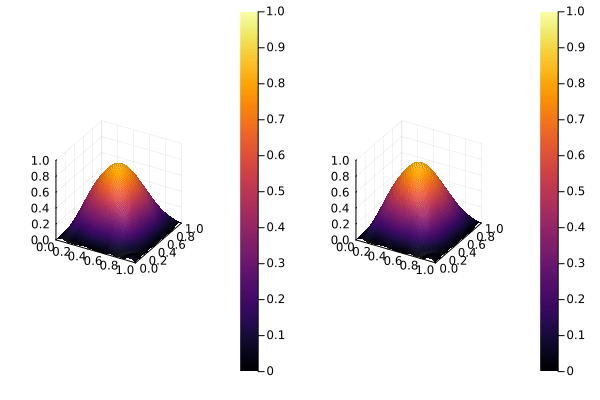

In [61]:
noelms1 = 4
noelms2 = 4
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
tol = 0.001
lam1 = lam2 = nu = 1.0
dt = 0.008
theta = 1.0

ct(x,y) = 1.0
qt(x,y) = 0.0
u(x,y,t) = exp(-2*pi^2*nu*t)*sin(pi*x)*sin(pi*y)                 # This is the analytical solution to the problem
g(x,y) = sin(pi*x)*sin(pi*y)                                    # This is u(x,y,0) 
f(x,y) = 0.0                                                    # This is the dirichlet boundary condition
ut(x,y,t) = nu *(-2*exp(-2*pi^2*nu*t)*pi^2*sin(pi*x)*sin(pi*y))   # This is the time derivative of u(x,y,t)
distD(x, y) = min(x-x0, y-y0,x0+L1-x, y0+L2-y)                  # This is the distance function for the dirichlet boundary

VX, VY = xy(x0, y0, L1, L2, noelms1, noelms2)
EToV = conelmtab(noelms1, noelms2)
uhat = g.(VX, VY)
bnodes = constructBnodes(VX, VY, tol, distD)
R, S, b = assembly(VX, VY, EToV, lam1, lam2, qt.(VX, VY), ct.(VX,VY))
R, S, b, d = dirbc(bnodes, f.(VX,VY), R, S, b)
R, S = updateRandS(R,S,dt,theta)
R = Symmetric(R)
S = Symmetric(S)

N = 20
uhats = zeros(length(VX), N)
errors = zeros(N)
t = 0.0

for i in 1:N
    t += dt

    uhat = solveTDDBVP(R,S,uhat)
    uhats[:, i] = uhat
    errors[i] = maximum(abs, uhat .- u.(VX, VY, t))
end

anim = @animate for i in 1:N
    p1 = plot(VX, VY, uhats[:,i], st=:surface, zlims=(0,1), clims =(0,1.0))
    p2 = plot(VX, VY, u.(VX,VY,i*dt), st=:surface, zlims=(0,1), clims =(0,1.0))
    plot(p1, p2, layout=(1,2))
end

gif(anim, "myGif.gif"; fps = 5)


# Exercise 5.3

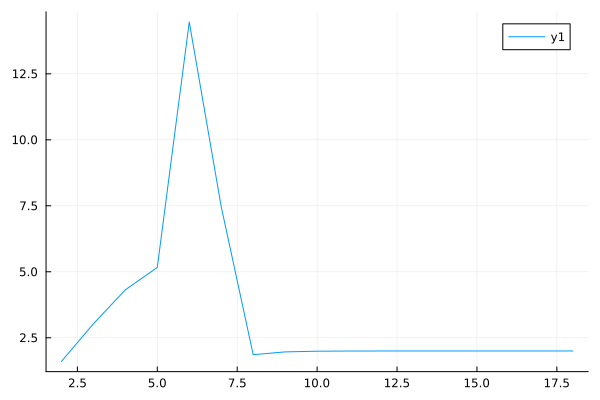

17-element Vector{Float64}:
  1.6040695453203628
  3.027575344195891
  4.317089392261176
  5.164837983760042
 14.463090919577713
  7.467319721850914
  1.86035241562465
  1.9652850873500178
  1.9913338762832056
  1.997834261302154
  1.9994586148861957
  1.9998646649533962
  1.9999662608269042
  1.9999917095706272
  2.0000032128765293
  2.0000774510462285
  2.0001383600967384

In [59]:
theta = 0.5
t = 1.0
P = 18
uhats = zeros(length(VX), P+1)
qp = zeros(P-1)

for p in 0:P
    dt = t/(2^p)
    uhat = g.(VX, VY)
    R, S, b = assembly(VX, VY, EToV, lam1, lam2, qt.(VX, VY), ct.(VX,VY))
    R, S, b, d = dirbc(bnodes, f.(VX,VY), R, S, b)
    R, S = updateRandS(R,S,dt,theta)
    R = Symmetric(R)
    S = Symmetric(S)
    for i in 1:div(t,dt)
        uhat = solveTDDBVP(R,S,uhat)
    end
    display(uhat)
    uhats[:,p+1] = uhat
    if p>=2
        qp[p-1] = log2(maximum(abs, (uhats[:,p-1]-uhats[:,p]))/maximum(abs, (uhats[:,p]-uhats[:,p+1])))
    end
end

display(plot(2:P,qp))
display(qp)